In [58]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
from sklearn.linear_model import LinearRegression as lin 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet as en 
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.ensemble import GradientBoostingRegressor as gb
from sklearn.ensemble import ExtraTreesRegressor as et
from sklearn.ensemble import HistGradientBoostingRegressor as hist
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor as dt
import pandas as pd
from bisect import bisect_left as bi
import warnings
warnings.simplefilter("ignore")

In [172]:
def generate_function_coefficients(func_specs,n=1):
    """

    sample function coeffieients from normal distribution
    """

    coeffs=np.zeros((n,len(func_specs)))
    for _ in range(n):
        for i in range(len(func_specs)):

            coeffs[_,i] = np.random.normal(loc=func_specs[i][0],scale=func_specs[i][1])
            
    return coeffs

def generate_func_output(func_coeffs, data, intercept):

    wo_noise = np.zeros(len(data))
    for i in range(len(data)):

        coeffs = func_coeffs[i%len(func_coeffs)]
        wo_noise[i]= (data[i]@coeffs) + intercept

    return wo_noise


def generate_correlated_samples(means,n,cov_mat):

    return mvn.rvs(mean = means, cov = cov_mat, size = n)


def bake_off_func_output(train, test, models, error_funcs):

    res = dict()

    for i in models:

        out=list()
        i.fit(train[:,:-1],train[:,-1])

        for j in error_funcs:
                  
            out.append(j(i.predict(test[:,:-1]).squeeze(), test[:,-1].squeeze()))
        
        res[str(i)]=out
        
    return res

def rmse(pred, true):

    return np.sqrt(sum((true-pred)**2)/len(pred))




In [236]:

def piecewise(input, funcs_dict, critical_vars, default_coeffs=None):
    """
    len of coeffs must be equal to total entries in critical points +1 for each critical var
    coeffs(funciton coefficients )
    critical_points- key=critical_var, val= array

    """

    keys = list(critical_vars.keys())

    #create dictionary to track how often each piece is used
    utilization_dict= dict()
    utilization_dict['default']=0
    for i in funcs_dict.keys():
        utilization_dict[i]=0
    
    y=np.zeros(len(input))
    for x in range(len(input)):

        key=np.zeros(len(keys))
        for i in range(len(key)):

            #get the bucket for this x array by critical variable
            pos = bi(critical_vars[keys[i]], input[x,i])
            key[i]=pos

        #get the proper coefficients for this input array
        key=tuple(key)
        if key in funcs_dict.keys():

            utilization_dict[key]+=1
            y[x]= input[x]@funcs_dict[key]
        else:
            utilization_dict['default']+=1
            y[x]= input[x]@ default_coeffs

    return y, utilization_dict

critical_vars = {0:[0.5,4], 1:[0.5,3,4,20]}
funcs_dict= {(0,0):[1,7,-13,4,50,0,0],(1,0):[3,4,3,0,3,0,0],(2,0):[3,10,3,-8,0,0,4],(0,1):[5,-3,3,0,-5,0,0],(0,2):[12,14,3,0,-4,0,-6],(0,3):[1,4,34,0,-4,0,6],(2,3):[-1,-4,34,0,-4,0,6],(1,4):[-1,-4,34,0,0,0,0],(1,3):[-1,20,6,0,6,0,0]}


#piecewise(data[:,:-1], funcs_dict, critical_vars, default_coeffs=[-1,-10,3,2,0])



In [237]:
a=np.random.exponential(scale=3, size=10000)

cont=0
for i in a:
    if i>4:
        cont+=1

print(cont)

2576


In [239]:
size=1000

a = np.random.exponential(scale = 3, size=size)
b = np.random.exponential(scale = 6, size=size)
c = np.clip(a+np.random.normal(0,4,size), 0, a_max=np.inf)
d = np.random.normal(0,10,size)
e = d+np.random.normal(0,10,size)
f = np.clip(a+np.random.normal(0,4,size), 0, a_max=np.inf)
g = np.clip(f+np.random.normal(0,4,size), 0, a_max=np.inf)
data = pd.DataFrame({'a':a,'b':b,'c':c,'d':d,'e':e,'f':f,'g':g}).to_numpy()

func_coeffs = [
    (4,0),
    (0,0),
    (-1,0),
    (4,0),
    (0,0),
]

default_coefs = [-1,-10,3,4,5,0,0]

#get coefficients in proper format
coeffs = generate_function_coefficients(func_coeffs, n=1)

#generate noise
noise=np.random.normal(0,4, size=size)

#generate function output
#y = (generate_func_output(coeffs, data, 0)+noise).reshape(-1,1)
y, util_dict = piecewise(data, funcs_dict, critical_vars, default_coefs)
y=y+noise
y=y.reshape(-1,1)

data = np.concatenate((data,y), axis=1)

print(f' data is of shape {data.shape}')
print('\n')

print('Coefficient Utilization')
for key, value in util_dict.items():

    print(f'{key}: {value}')


train=data[:int(size/2)]
test=data[int(size/2):]

models = [
    lin(),
    Ridge(),
    Lasso(),
    en(),
    rf(),
    gb(),
    et(),
    dt()
]
#print corr matrix of variables
print('Correlation matrix')
print(pd.DataFrame(data).corr())
print('\n')
print('\n')

#train models and report TEST RMSE
res = bake_off_func_output(train,test,models,[rmse])
print('Models and Test Errors')

for key, value in res.items():

    print(f'{key}: {value}')

print('\n')
print('\n')


#gather the trained on coefficients for now
observed_coef = weighted_coefs_from_util(funcs_dict, util_dict,default_coefs)

#grab all coefficient estimates
estimates = get_coef_estimates(models, train)

ranks_by_coef_error = rank_by_coef_error(estimates, observed_coef)

print('Cosine Sim errors for func weights')

for key, value in ranks_by_coef_error.items():
    print(f'{key}: {value}')

 data is of shape (1000, 8)


Coefficient Utilization
default: 348
(0, 0): 15
(1, 0): 44
(2, 0): 19
(0, 1): 50
(0, 2): 10
(0, 3): 65
(2, 3): 144
(1, 4): 24
(1, 3): 281
Correlation matrix
          0         1         2         3         4         5         6  \
0  1.000000  0.021436  0.625575 -0.005005 -0.004667  0.651102  0.468656   
1  0.021436  1.000000  0.022226  0.015830  0.044423  0.022713  0.042798   
2  0.625575  0.022226  1.000000 -0.000302 -0.029315  0.426095  0.314930   
3 -0.005005  0.015830 -0.000302  1.000000  0.694082  0.039439  0.044987   
4 -0.004667  0.044423 -0.029315  0.694082  1.000000  0.035260  0.036360   
5  0.651102  0.022713  0.426095  0.039439  0.035260  1.000000  0.732706   
6  0.468656  0.042798  0.314930  0.044987  0.036360  0.732706  1.000000   
7  0.190695  0.293170  0.291515  0.207165  0.285239  0.179373  0.167490   

          7  
0  0.190695  
1  0.293170  
2  0.291515  
3  0.207165  
4  0.285239  
5  0.179373  
6  0.167490  
7  1.000000  




Models 

TypeError: 'ExtraTreeRegressor' object is not subscriptable

In [213]:
estimates

{LinearRegression(): array([-1.70257489e+00, -1.00252392e+01,  3.04034549e+00,  3.66026724e+00,
         5.06866836e+00, -4.07246211e-03,  5.45713243e-01]),
 Ridge(): array([-1.69940967e+00, -1.00239388e+01,  3.03823998e+00,  3.66001817e+00,
         5.06867822e+00, -4.82000203e-03,  5.45900506e-01]),
 Lasso(): array([-1.38947918, -9.98367314,  2.8639996 ,  3.63765632,  5.0725136 ,
        -0.        ,  0.4653519 ]),
 ElasticNet(): array([-1.25612644, -9.84746096,  2.72956393,  3.6214223 ,  5.07088025,
        -0.02012839,  0.50044597]),
 RandomForestRegressor(): array([ 2.03437133e+01,  2.32199132e+01, -2.32372197e+00, -2.46338136e+00,
         1.46135861e+01, -2.79083775e+00,  5.16144975e-03]),
 GradientBoostingRegressor(): array([ 3.41467849,  2.67036119, -0.59192347,  0.11096912,  1.1630428 ,
         0.0380318 , -0.00346341]),
 ExtraTreesRegressor(): array([-30.54438607,  24.46804388,  -5.90397965,  -1.20849629,
         14.84503271,  -0.33284359,  -0.10890015]),
 DecisionTreeRegr

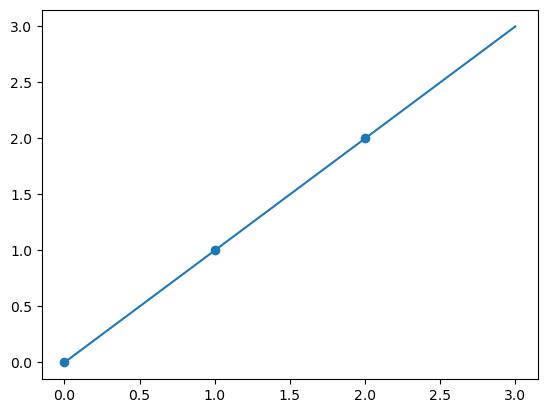

In [254]:
plt.scatter([0,1,3],[0,1,2])
plt.plot(np.linspace(0,3,100), mod.predict(np.linspace(0,3,100).reshape(-1,1)))
plt.show()

In [298]:
m = mod.coef_[0]
n=

mean = 0
for i in range(1,n):

    mean+= m*i

mean=mean/n

res=0
for i in range(n):

    y=m*i

    if i!=n/2:
        res+=(y-mean)/(i - n/2)

print(res/(n-1))

print(m)



[0.64279221]
[0.64285714]


In [283]:
list(range(1,2))

[1]

In [295]:
(0.67678571+0.64116541)/2

0.65897556

In [258]:
(((-1)/(0-4/3)) + ((0)/(2-4/3)) +(1/(3-4/3)))/3

0.45

In [263]:
mod = lin()
mod.fit([[0],[1],[3]],[[0],[1],[2]])


LinearRegression()

In [183]:
for key,value in estimates.items():
    print(value.reshape(1,-1))
    print(observed_coef.reshape(1,-1))
    print(cosine_similarity(value.reshape(1,-1),observed_coef.reshape(1,-1)))

[[-0.45479154  1.16554311 -0.19897999  0.93781663]]
[[ 2.744  4.384  3.    -1.136  3.05 ]]


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 4 while Y.shape[1] == 5

In [148]:
#todo: calcualte average params from util dict and create function to calculate distance from esimtated params by model
from sklearn.metrics.pairwise import cosine_similarity

def weighted_coefs_from_util(funcs_dict, util_dict, defaults):

    avg = np.zeros(len(defaults))
    funcs_dict['default']=np.array(defaults)
    tot = 0
    for i in util_dict:

        avg += util_dict[i]*np.array(funcs_dict[i])
        tot+= util_dict[i]
    
    return avg/tot






In [155]:
def get_coef_estimates(models, train):

    res = dict()
    for i in models:

        #this is an ensemble model
        if hasattr(i, 'estimators_'):

            est = estimate_all_coefs_for_dataset(train[:,:-1], i)
            res[i]=np.nanmean(est,axis=0)

        #this is a decision tree
        elif hasattr(i, 'tree_'):

            est = estimate_all_coefs_for_dataset(train[:,:-1],i, ensemble=False)
            res[i]=np.nanmean(est, axis=0)

        #this is a regression model
        else:
            res[i]=i.coef_

    return res

#get model estimates of all coefficients
estimates = get_coef_estimates(models, train)






TypeError: 'DecisionTreeRegressor' object is not subscriptable

In [177]:
# import matplotlib.pyplot as plt
# from sklearn.tree import plot_tree
# plt.figure(figsize=(10,15))
# a = plot_tree(models[-1])

def rank_by_coef_error(models, weighted_coefs):

    res=dict()
    for key, val in models.items():

        res[key] = cosine_similarity(val.reshape(1,-1), weighted_coefs.reshape(1,-1))
    
    return res
    

In [26]:
def traverse_to_node(x, tree, feature, i=0, prop=1):
        """ 
        tree: decision tree object
        feature: feature that we are holding blank
        i: index at which to begin in attribute arrays
        prop: proportion of weight we are assigning to this prediction
        """

        #return prediction with proper proportion if this is a node
        if tree.children_left[i]==-1:

            return (tree.value[i][0][0], prop)
            
        #normal traverse if this is not the feature of interest
        if tree.feature[i]!= feature:
             
             if x[tree.feature[i]] <= tree.threshold[i]:
                  
                  return traverse_to_node(x, tree, feature, i = tree.children_left[i], prop = prop)
             else:
                  return traverse_to_node(x, tree, feature, i = tree.children_right[i], prop = prop)

        #otherwise we need to do proportional split without conditioning on the value of feature
        else:
            
            #aesthetic only
            samps = tree.n_node_samples

            #traverse to left with proper proportions
            prop_left = prop * samps[tree.children_left[i]]/samps[i]
            left =traverse_to_node(x, tree, feature, i = tree.children_left[i], prop = prop_left)
            
            
            #traverse to right with proper proportions
            prop_right = prop * samps[tree.children_right[i]]/samps[i]
            right = traverse_to_node(x, tree, feature, i = tree.children_right[i], prop = prop_right)
            
            return (left[0]*(left[1]/(left[1]+right[1])) + right[0]*(right[1]/(left[1]+right[1])),left[1]+right[1])
        

(7.220267001025663, 1.0)

In [175]:
def coef_impact_estimate(x, tree, feature, feature_mean, pred_val):

    #don't want to include impact on coeff if 0
    if x[feature]==0:
        return None
    
    #get masked_prediction
    masked_pred_val = traverse_to_node(x, tree, feature)[0]

    return (pred_val - masked_pred_val) / x[feature]

def estimate_all_coefs(x, tree):

    #create array to catch coeff estimates
    ests = np.zeros(len(x))

    #get unmasked prediction value
    try:
        pred_val = tree.predict(x.astype('float32').reshape(1,-1))[0]
    except:
        print (x)
    for i in range(len(x)):

        ests[i] = coef_impact_estimate(x, tree, feature=i, pred_val = pred_val)

    return ests

def estimate_all_coefs_ensemble(x, mod):

    ests = np.zeros((len(mod.estimators_),len(x)))

    for i in range(len(x)):
        for j in range(len(mod.estimators_)):

            #catch RF and GBM being organized differently. very sloppy
            try:
                pred_val = mod.estimators_[j].predict([x])
                ests[j,i] = coef_impact_estimate(x, mod.estimators_[j].tree_, feature =i, pred_val=pred_val)
            except:
                pred_val = mod.estimators_[j][0].predict([x])
                ests[j,i] = coef_impact_estimate(x, mod.estimators_[j][0].tree_, feature =i, pred_val=pred_val)

    return np.nanmean(ests, axis=0)

def estimate_all_coefs_for_dataset(x, mod, ensemble=True):

    res = np.zeros(x.shape)
    for i in range(len(x)):

        if ensemble:
            res[i] = estimate_all_coefs_ensemble(x[i], mod)

        else:
            res[i] = estimate_all_coefs(x[i], mod.tree_)

    return res




In [26]:
import numpy as np
l1 = [1,1,0]
l2 = [1,1,1,0,0]

tot = 0
l1_ = 0
seen = 0
for i in range(100000):

    lit = np.random.choice([0,1])

    if lit==0:
        pup = np.random.choice(l1)
        tot += pup

        if pup==0:
            l1_+=1
            seen+=1

    else:
        pup = np.random.choice(l2)
        tot+=pup

        if pup==0:
            seen+=1

print(tot/100000)
print(l1_/seen)


0.63354
0.4527642853244556


In [27]:
g100=0
for _ in range(10000):

    unc=0
    for i in range(2000):

        a=np.random.choice([0,1], p=[0.01,0.99])

        if a==0:
            unc+=1
    if unc>99:
        g100+=1

print(g100/10000)

0.0


In [ ]:
from scipy.stats import binom